# Exercise 06 : Scatter Matrix

Dataframe contains 11 rows: PASSED


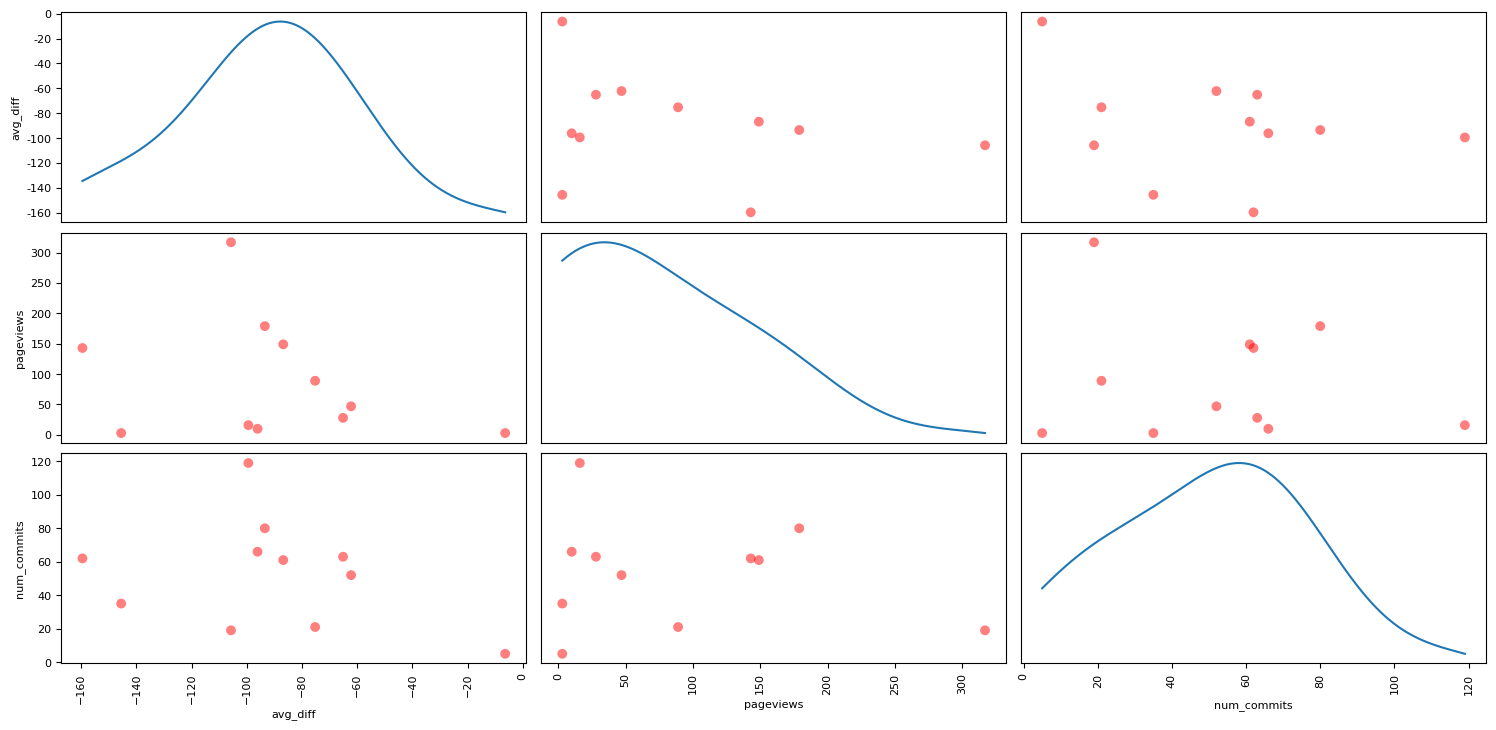

In [ ]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

pd.plotting.plot_params.update({'font.size': 8})

con = sqlite3.connect(r"../data/checking-logs.sqlite")

deadlines = pd.read_sql("SELECT labs, deadlines FROM deadlines", con)

chk = pd.read_sql("SELECT uid, labname, timestamp, numTrials FROM checker WHERE uid LIKE 'user_%'", 
                  con, parse_dates=['timestamp'])

chk['first_time'] = chk.groupby(['uid', 'labname'])['timestamp'].transform('min')
firsts = chk.drop_duplicates(subset=['uid', 'labname'])[['uid', 'labname', 'first_time']]

data = firsts.merge(deadlines, left_on='labname', right_on='labs', how='left')
data = data[data['labname'] != 'project1']

data['deadlines_dt'] = pd.to_datetime(data['deadlines'], unit='s')
data['diff_hours'] = (data['first_time'] - data['deadlines_dt']).dt.total_seconds() / 3600

avg_diff = data.groupby('uid')['diff_hours'].mean().rename('avg_diff')

pageviews = pd.read_sql("""
    SELECT uid, COUNT(*) as pageviews 
    FROM pageviews 
    WHERE uid LIKE 'user_%' 
    GROUP BY uid
""", con).set_index('uid')

commits = chk[chk['labname'] != 'project1'].groupby('uid').size().rename('num_commits')

users = pd.concat([avg_diff, pageviews, commits], axis=1, join='inner')

# print("Data ranges:")
# print(f"avg_diff: {users['avg_diff'].min():.1f} to {users['avg_diff'].max():.1f}")
# print(f"num_commits: {users['num_commits'].min()} to {users['num_commits'].max()}")
# print(f"pageviews: {users['pageviews'].min()} to {users['pageviews'].max()}")

axes = scatter_matrix(
    users, 
    figsize=(15, 8),
    diagonal='kde',
    s=200,
    color='red',
    linewidth=3,
    range_padding=0.1
)

fig = axes[0][0].get_figure()
# fig.suptitle('Relationship between avg_diff, pageviews and num_commits', fontsize=15)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

con.close()

df_rows = len(users)
print(f"Dataframe contains {df_rows} rows: {'PASSED' if df_rows == 11 else 'FAILED'}")

**Answers to questions:**
1. Can we say that if a user has a low number of pageviews then they likely have a low number of commits?  
   **no**
2. Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?  
   **no**
3. Can we say that there are many users with a low number of commits and a few with a high number of commits?  
   **yes**
4. Can we say that there are many users with a small average difference and a few with a large average difference?  
   **no**